# Heuristic CNN-based Policy

The new heuristic Policy combines two Convolutional models:

- Hard Policy: a model that reliably identifies critical MUST-CONSIDER patterns
- Soft Policy: a model that prefers fields that are strongly connected (via common lines) with other stones

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from domoku import data
from domoku.policies.softadvice import MaxInfluencePolicyParams, MaxInfluencePolicy
from domoku.tools import GomokuTools as Gt
from domoku import jupyter_tools as jt
from domoku.board import GomokuBoard

from domoku.policies.maximal_criticality import MaxCriticalityPolicy

In [3]:
SIZE=7

# Combine Soft Advice with Criticality Comprehension

In [4]:
examine = 'b2b6c4d4d5e2b4c5'

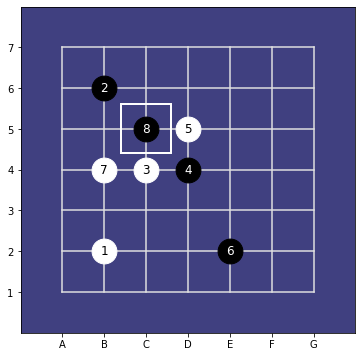

In [9]:
stones = Gt.string_to_stones(examine)
board = GomokuBoard(n=SIZE, disp_width=6, stones=stones)
board.display()

In [13]:
from alphazero.gomoku_board import Board

board = Board(SIZE, examine, x_means='b')

In [15]:
board.plot()
board

                             
 7    .  .  .  .  .  .  .    
 6    .  0  .  .  .  .  .    
 5    .  .  0  X  .  .  .    
 4    .  X  X  0  .  .  .    
 3    .  .  .  .  .  .  .    
 2    .  X  .  .  0  .  .    
 1    .  .  .  .  .  .  .    
                             
      A  B  C  D  E  F  G


B2 B6 C4 D4 D5 E2 B4 C5 

In [16]:
board.act('E', 3)

B2 B6 C4 D4 D5 E2 B4 C5 E3 

In [17]:
board.plot()

                             
 7    .  .  .  .  .  .  .    
 6    .  0  .  .  .  .  .    
 5    .  .  0  X  .  .  .    
 4    .  X  X  0  .  .  .    
 3    .  .  .  .  X  .  .    
 2    .  X  .  .  0  .  .    
 1    .  .  .  .  .  .  .    
                             
      A  B  C  D  E  F  G


In [18]:
sample = board.math_rep
jt.print_bin(sample, combine=True)

shape: (9, 9, 3)
[[3 3 3 3 3 3 3 3 3]
 [3 0 0 0 0 0 0 0 3]
 [3 0 1 0 0 0 0 0 3]
 [3 0 0 1 2 0 0 0 3]
 [3 0 2 2 1 0 0 0 3]
 [3 0 0 0 0 2 0 0 3]
 [3 0 2 0 0 1 0 0 3]
 [3 0 0 0 0 0 0 0 3]
 [3 3 3 3 3 3 3 3 3]]


In [19]:
from domoku.constants import BLACK

hard_policy = MaxCriticalityPolicy(board_size=SIZE, overconfidence=2.0)
params = MaxInfluencePolicyParams(
    board_size=SIZE,
    sigma=.8,
    iota=20,
    radial_constr = [.0625, .125, .25, .5],
    radial_obstr = [-.0625, -.125, -.25, -.5]
)
soft_policy = MaxInfluencePolicy(params, criticality_model=None, pov=BLACK)

2022-06-04 15:48:27.445384: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/wgiersche/.local/share/virtualenvs/DeepGomoku-cXtJ_EtM/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [20]:
jt.vis(soft_policy(sample), scale=100)

[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0 53 40  9  0  0  0  0]
 [ 0  0  0 11  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]]


In [26]:
move = soft_policy.sample(sample, 1, board=board)[0]
move

B3

---

# A Complete Game!

The mixed policy puts stones next to each other until it recoginizes a double-open 3 and then finishes the game.
With this policy, we're able to create loads of short, yet somewhat meaningful trajectories for training.

In [27]:
SIZE = 15

In [28]:
hard_policy = MaxCriticalityPolicy(board_size=SIZE, overconfidence=5.0)
params = MaxInfluencePolicyParams(
    board_size=SIZE,
    sigma=.6,
    iota=6,
    radial_constr = [.0625, .125, .25, .5],
    radial_obstr = [-.0625, -.125, -.25, -.5]
)
soft_policy = MaxInfluencePolicy(params, criticality_model=hard_policy, pov=BLACK)

In [305]:
board = Board(SIZE, stones='H8')
sample = board.math_rep.copy()

In [320]:
move = soft_policy.sample(sample, 1, board=board)[0]
board.act(move)
sample = board.math_rep
winner = hard_policy.winner(sample)
board.plot()
if winner is not None:
    print("**********************************************************")
    print("")
    print(f"                      TERMINATED")
    print("")
    print("**********************************************************")
print("")
print(f"Board: {board}")

                                                     
15    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
14    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
13    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
12    .  .  .  .  X  .  .  .  .  .  .  .  .  .  .    
11    .  .  .  .  .  0  X  .  X  .  .  .  .  .  .    
10    .  .  .  .  .  0  0  X  .  .  .  .  .  .  .    
 9    .  .  .  .  .  .  X  0  .  .  .  .  .  .  .    
 8    .  .  .  .  .  .  X  X  0  .  .  .  .  .  .    
 7    .  .  .  .  .  .  X  .  .  0  .  .  .  .  .    
 6    .  .  .  .  .  0  0  .  .  .  .  .  .  .  .    
 5    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 4    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 3    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 2    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 1    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
                                                     
      A  B  C  D  E  F  G  H  I  J  K  L  M  N  O
********************************